<a href="https://colab.research.google.com/github/manideep7575/KMNIST-AN/blob/main/KMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 18.2M/18.2M [00:08<00:00, 2.26MB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 781kB/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 2.96MB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 3.61MB/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



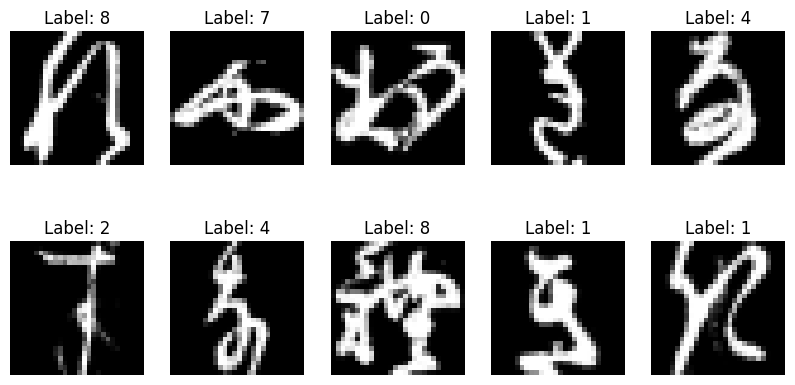

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load and transform KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, transform=transform, download=True)

# Plot sample images from KMNIST
def plot_sample_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Display sample images from KMNIST
plot_sample_images(train_dataset)

In [2]:
import torch
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size, activation='relu', weight_init='xavier'):
        super(FeedforwardNN, self).__init__()
        layers = []
        in_features = input_size

        for _ in range(hidden_layers):
            layer = nn.Linear(in_features, hidden_units)

            # Weight Initialization
            if weight_init == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)  # Initialize bias as zero
            elif weight_init == 'random':
                nn.init.uniform_(layer.weight, -1, 1)
                nn.init.uniform_(layer.bias, -0.5, 0.5)

            layers.append(layer)

            # Activation Function
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())

            in_features = hidden_units  # Update input size for next layer

        layers.append(nn.Linear(hidden_units, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input to [batch_size, 28*28]
        return self.network(x)

In [3]:
import torch
from torch.utils.data import random_split, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Split KMNIST into train and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader configurations
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
from tqdm import tqdm  # For progress bars

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler=None, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    patience_counter = 0  # For early stopping

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0  # For tracking training accuracy

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation Loop
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total

        # Learning Rate Scheduler (if used)
        if scheduler:
            scheduler.step(val_loss / len(val_loader))

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # Reset patience if validation improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.3f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    return model

In [5]:
import torch.optim.lr_scheduler as lr_scheduler

# Hyperparameters
input_size = 28 * 28
output_size = 10
hidden_layers = 3
hidden_units = 64
activation = 'relu'
weight_init = 'xavier'
epochs = 10
learning_rate = 1e-3
optimizer_choice = 'adam'
weight_decay = 1e-4  # Regularization to reduce overfitting

# Model and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN(input_size, hidden_layers, hidden_units, output_size, activation, weight_init).to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer Selection
optimizer_dict = {
    'sgd': optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
    'momentum': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay),
    'nesterov': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay),
    'rmsprop': optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
    'adam': optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
}

optimizer = optimizer_dict[optimizer_choice]

# Learning Rate Scheduler (Recommended for smoother convergence)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Train the Model
model = train_model(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler)

Epoch 1/10: 100%|██████████| 1688/1688 [00:19<00:00, 87.51it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/10] - Loss: 0.485 | Train Acc: 84.59% | Val Acc: 89.55%


Epoch 2/10: 100%|██████████| 1688/1688 [00:18<00:00, 90.84it/s] 


Epoch [2/10] - Loss: 0.265 | Train Acc: 91.67% | Val Acc: 91.18%


Epoch 3/10: 100%|██████████| 1688/1688 [00:19<00:00, 87.32it/s]


Epoch [3/10] - Loss: 0.215 | Train Acc: 93.31% | Val Acc: 92.52%


Epoch 4/10: 100%|██████████| 1688/1688 [00:18<00:00, 92.09it/s] 


Epoch [4/10] - Loss: 0.179 | Train Acc: 94.33% | Val Acc: 92.87%


Epoch 5/10: 100%|██████████| 1688/1688 [00:19<00:00, 85.67it/s] 


Epoch [5/10] - Loss: 0.156 | Train Acc: 95.07% | Val Acc: 93.05%


Epoch 6/10: 100%|██████████| 1688/1688 [00:18<00:00, 92.19it/s]


Epoch [6/10] - Loss: 0.139 | Train Acc: 95.56% | Val Acc: 93.65%


Epoch 7/10: 100%|██████████| 1688/1688 [00:19<00:00, 85.37it/s] 


Epoch [7/10] - Loss: 0.128 | Train Acc: 95.85% | Val Acc: 93.47%


Epoch 8/10: 100%|██████████| 1688/1688 [00:19<00:00, 88.20it/s]


Epoch [8/10] - Loss: 0.116 | Train Acc: 96.30% | Val Acc: 93.42%


Epoch 9/10: 100%|██████████| 1688/1688 [00:18<00:00, 92.36it/s]


Early stopping triggered at epoch 9
Best Validation Accuracy: 93.65%


Test Accuracy: 86.68%


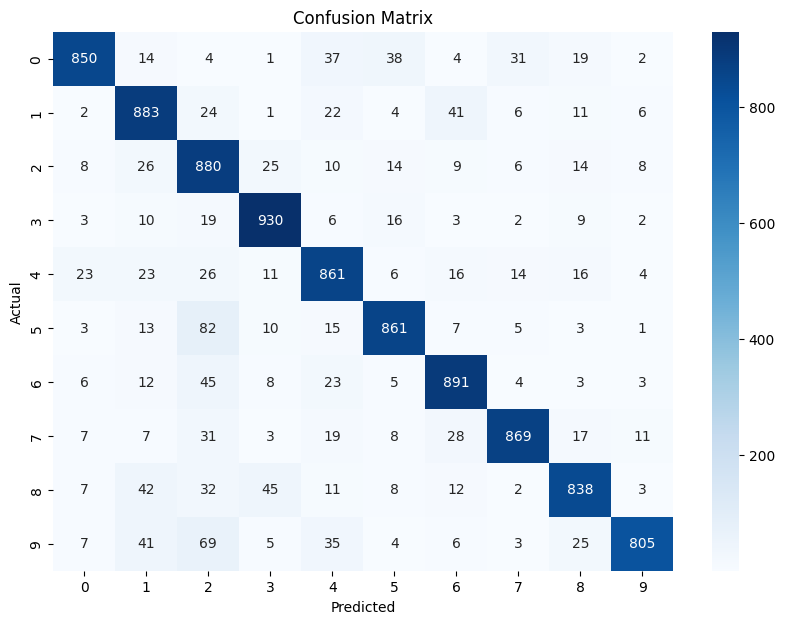

In [6]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return all_labels, all_preds

all_labels, all_preds = evaluate(model, test_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [7]:

criterion_mse = nn.MSELoss()
loss_mse = criterion_mse(torch.nn.functional.one_hot(torch.tensor(all_labels), num_classes=10).float(),
                         torch.nn.functional.one_hot(torch.tensor(all_preds), num_classes=10).float())
print(f'MSE Loss: {loss_mse.item():.4f}')

MSE Loss: 0.0266
